## Access Satellite Ghrsst L4 Ramssa 1Day Multi Sensor Australia data in Parquet
A jupyter notebook to show how to access and plot the AODN satellite_ghrsst_l4_ramssa_1day_multi_sensor_australia dataset available as a [Zarr](https://zarr.dev/)  dataset on S3

In [1]:
dataset_name = "satellite_ghrsst_l4_ramssa_1day_multi_sensor_australia"

In [2]:
import xarray as xr
import fsspec

## Install/Update packages and Load common functions

In [3]:
# only run once, then restart session if needed
!pip install uv

import os
import sys

def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_colab():
    os.system('uv pip install --system -r https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt')
else:
    os.system('uv venv')
    os.system('uv pip install -r https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt')

Using Python 3.12.4 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python3
Creating virtualenv at: .venv
Activate with: source .venv/bin/activate
Audited 128 packages in 4.85s


In [4]:
# remote zarr dataset
url = f's3://aodn-cloud-optimised/{dataset_name}.zarr/'
ds = xr.open_zarr(fsspec.get_mapper(url, anon=True), consolidated=True)
ds

<xarray.Dataset> Size: 315GB
Dimensions:           (time: 6668, lat: 1081, lon: 1561)
Coordinates:
  * lat               (lat) float32 4kB -70.0 -69.92 -69.83 ... 19.83 19.92 20.0
  * lon               (lon) float32 6kB 60.0 60.08 60.17 ... 189.8 189.9 190.0
  * time              (time) datetime64[ns] 53kB 2006-06-12T12:00:00 ... 2024...
Data variables:
    analysed_sst      (time, lat, lon) float64 90GB dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 90GB dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    crs               int32 4B ...
    mask              (time, lat, lon) float32 45GB dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 90GB dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
Attributes: (12/65)
    Conventions:                CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Link:              https://podaac.jpl.nasa.gov/ws/metadata/datas...
    acknowledgment:             Any use of these data requires the following ...
    cdm_data_type:              Grid
    comment:                    This is a Bureau of Meteorology experimental ...
    contributor_name:           Helen Beggs
    ...                         ...
    time_coverage_end:          20240719T000000Z
    time_coverage_resolution:   P1D
    time_coverage_start:        20240718T000000Z
    title:                      RAMSSA v1.1 Analysed high resolution foundati...
    uuid:                       2cf49998-168b-42df-97ef-30229d4a1071
    westernmost_longitude:      0.0

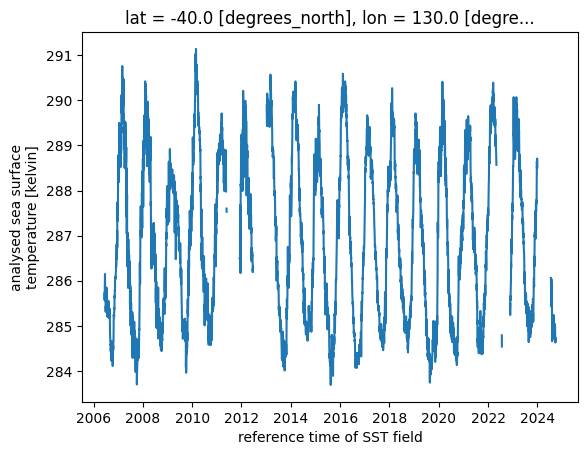

In [5]:
ds.analysed_sst.sel(lat=-40, lon=130, method='nearest').plot()

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import traceback

def plot_sst(ds, start_date, lon_slice, lat_slice, sst_var='sea_surface_temperature'):
    """
    Plots SST data for 6 consecutive days starting from start_date.

    Parameters:
    - ds: xarray.Dataset containing the SST data.
    - start_date: str, start date in 'YYYY-MM-DD' format.
    - lon_slice: tuple, longitude slice (start_lon, end_lon). (min val, max val)
    - lat_slice: tuple, latitude slice (start_lat, end_lat). (min val, max val)
    """

    # decide on the slice order
    if ds.lat[0] < ds.lat[-1]:
        lat_slice = lat_slice
    elif ds.lat[0] > ds.lat[-1]:  
        # we reverse the slice
        lat_slice = lat_slice[::-1]
        
    # Parse the start date
    start_date_parsed = pd.to_datetime(start_date)

    # Ensure the dataset has a time dimension and it's sorted
    assert 'time' in ds.dims, "Dataset does not have a 'time' dimension"
    ds = ds.sortby('time')
    
    # Find the nearest date in the dataset
    nearest_date = ds.sel(time=start_date_parsed, method='nearest').time
    print(nearest_date)
    
    # Get the index of the nearest date
    nearest_date_index = ds.time.where(ds.time == nearest_date, drop=True).squeeze().values
    
    # Find the position of the nearest date in the time array
    nearest_date_position = int((ds.time == nearest_date_index).argmax().values)
    
    # Get the next 6 date values including the nearest date
    dates = ds.time[nearest_date_position:nearest_date_position + 6].values
    dates = [pd.Timestamp(date) for date in dates]

    # Create subplots
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
    axes = axes.flatten()

    # Plot SST for each date
    for ax, date in zip(axes, dates):
        try:
            sst_data = ds[sst_var].sel(time=date.strftime('%Y-%m-%d'), lon=slice(lon_slice[0], lon_slice[1]), lat=slice(lat_slice[0], lat_slice[1]))

            if ds[sst_var].units.lower() == 'kelvin':
                # Convert Kelvin to Celsius for plotting
                sst_data = sst_data - 273.15
            
            sst_data.plot(ax=ax, cmap='coolwarm', cbar_kwargs={'label': 'SST (°C)'})  # Using 'coolwarm' colormap
            ax.set_title(date.strftime('%Y-%m-%d'))

        except TypeError as err:
            # Print traceback for the KeyError
            #traceback.print_exc()
            # Handle the case where data for a specific date is not available
            print(f"{err}")
            ax.set_title(f"No data for {date.strftime('%Y-%m-%d')}")
            ax.axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()

<xarray.DataArray 'time' ()> Size: 8B
array('2022-01-02T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2022-01-02T12:00:00
Attributes:
    axis:                   T
    comment:                Nominal time because observations are from differ...
    coverage_content_type:  coordinate
    long_name:              reference time of SST field
    standard_name:          time


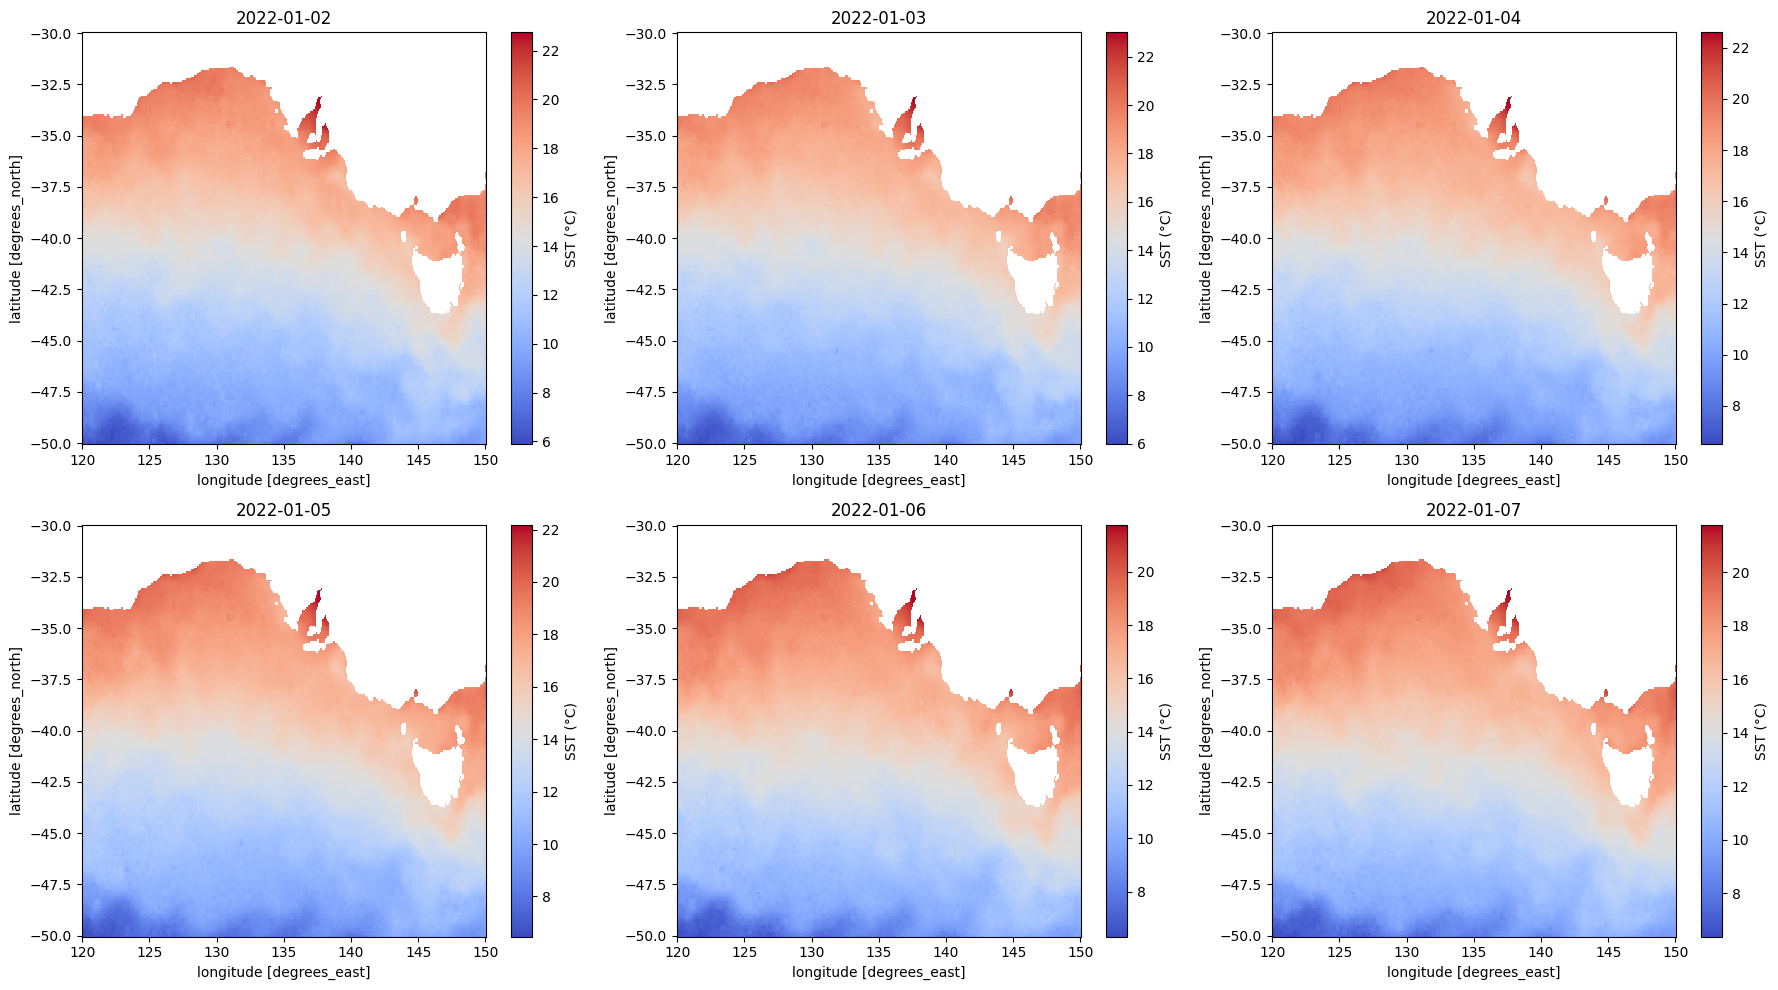

In [7]:
plot_sst(ds, start_date='2022-01-02', lon_slice=(120, 150), lat_slice=(-50, -30), sst_var='analysed_sst')